In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("data_1.zip", 'r')
zip_ref.extractall()
zip_ref.close()

[[ 35  57 160 160]]


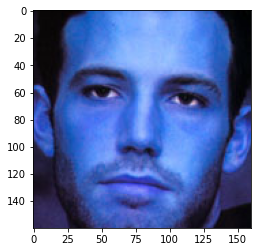

In [ ]:
face_cascade = cv2.CascadeClassifier('haar.xml') #loading the haar.xml file
f = cv2.imread("data/train/ben_afflek/httpwwwallposterscomimagesPostersPFjpg.jpg")
faces = face_cascade.detectMultiScale(f,1.3,5) # applying the classification on image and cropping the face only
print(faces) # printing the values of x, y, width, height
for x,y,w,h in faces:
    plt.imshow(f[y:y+h, x:x+w])  # plotting the image

In [ ]:
face_cascade = cv2.CascadeClassifier('haar.xml')
dirs = "data/train/"
img_size = 60
## train size 
## har ek image per model lga rahe hen
data = []
for name in os.listdir(dirs):
    for f in os.listdir(dirs+name):
        f = cv2.imread(os.path.join(dirs+name, f))
        faces = face_cascade.detectMultiScale(f,1.3,5)
        for x,y,w,h in faces:
            img = f[y:y+h, x:x+w]
            img = cv2.resize(img, (img_size,img_size))
            data.append((img, name))
            
df = pd.DataFrame(data, columns=["image", "name"])
print("Length:",len(df))
df.head()

Length: 99


,image,name
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",elton_john
1,"[[[127, 142, 168], [151, 164, 189], [159, 170,...",elton_john
2,"[[[29, 29, 29], [30, 30, 30], [30, 30, 30], [3...",elton_john
3,"[[[9, 16, 13], [7, 16, 13], [8, 17, 14], [6, 2...",elton_john
4,"[[[187, 118, 78], [186, 117, 74], [183, 115, 7...",elton_john


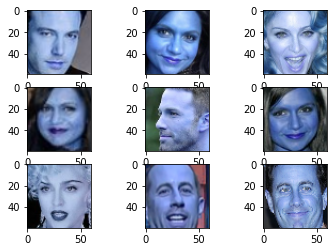

In [ ]:
for i in range(9):
  row = df.iloc[np.random.randint(0, len(df)), :]
  plt.subplot(3,3,i+1)
  plt.imshow(row.image)

In [ ]:
dirs = "data/val/"
## test dataset per ab lga  rahe hen apna cascade classifier
data = []
for name in os.listdir(dirs):
    for f in os.listdir(dirs+name):
        f = cv2.imread(os.path.join(dirs+name, f))
        faces = face_cascade.detectMultiScale(f,1.3,5)
        for x,y,w,h in faces:
            img = f[y:y+h, x:x+w]
            img = cv2.resize(img, (img_size,img_size))
            data.append((img, name))
            
df_test = pd.DataFrame(data, columns=["image", "name"])
print("Test size: ", len(df_test))

Test size:  24


In [ ]:
## Encode target labels with value between 0 and n_classes-1
#This transformer should be used to encode target values, i.e. y, and not the input X
## total 5 logo ke dataset he un paancho ko humne encode kardiya and upe values chahdha di
le = LabelEncoder()
le.fit(df["name"].values)

LabelEncoder()

In [ ]:
# jo values humne train karni he vo nikal li
# usse X_train me daal diya
x_train = list(df.image.values)
x_train = np.array(x_train)
x_train = x_train/255   # divide by 255 isliye kra taako vo 0-1 ke beech me aa jaaie
print(x_train.shape)
print(x_train)
#y_train me jitne total images he vo transform hori he
## BASICALLY TRANSFORM KYA KARTA HE VO, FIT LABEL ENCODE AND RETURN ENCODED LABELS
y_train = le.transform(df["name"].values)
print(y_train.shape)
print(y_train)

(99, 60, 60, 3)
[[[[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.22352941 0.22352941 0.14901961]
   [0.24705882 0.23921569 0.16470588]
   [0.3372549  0.3254902  0.24313725]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.50588235 0.5254902  0.41568627]
   [0.42745098 0.44313725 0.33333333]
   [0.32156863 0.31372549 0.21960784]]

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.66666667 0.70588235 0.56078431]
   [0.51372549 0.5372549  0.40784314]
   [0.32941176 0.32941176 0.22745098]]

  ...

  [[0.01176471 0.00392157 0.        ]
   [0.00392157 0.         0.        ]
   [0.         0.         0.00392157]
   ...
   [0.45098039 0.43137255 0.3372549 ]
   [0.10196078 0.07843137 0.00392157]
   [0.08235294 0.05882353 0.00784314]]

  [[0.01176471 0.00392157 0. 

In [ ]:
# same humne test vaali values per bhi kardiya

x_test = list(df_test.image.values)
x_test = np.array(x_test)
x_test = x_test/255
print(x_test.shape)

y_test = le.transform(df_test["name"].values)
print(y_test.shape)

(24, 60, 60, 3)
(24,)


In [ ]:
## kitne unique bande hen hamare dataset me vo print kar diya
people_num = len(np.unique(y_train))
people_num

5

In [ ]:
## we ha eto minimize the differnence between positive and negative

def triplet_loss(y_true, y_pred, alpha = 0.2):
    print(y_pred)
    total_lenght = y_pred.shape.as_list()[-1]
    anchor, positive, negative = y_pred[:,:int(1/3*total_lenght)], y_pred[:,int(1/3*total_lenght):int(2/3*total_lenght)], y_pred[:,int(2/3*total_lenght):]
    
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)   # distance between anchor and postive 
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)   # distance between anchor and negative
    basic_loss = pos_dist - neg_dist + alpha
    loss = tf.reduce_sum(tf.maximum(basic_loss,0.0))
    return loss

In [ ]:
## |encoding(anchor)-encding(positive)|^2  <=    encoding(anchor)-encding(negative)|^2
 ##             d(A,P)                                         d(A,N)
 ## d is distnace function
 ## choose triplet that are hard to train 
 ## during training if A,P,N are chosen randomly then
 ## d(A,P)+ alpha <=d(A,N) is easily statisfied
def generate_triplets(x, y, num_same = 4, num_diff = 4):
    anchor_images = np.array([]).reshape((-1,)+ x.shape[1:])
    same_images = np.array([]).reshape((-1,)+ x.shape[1:])
    diff_images = np.array([]).reshape((-1,)+ x.shape[1:])
    
    for i in range(len(y)):
        point = y[i]        
        anchor = x[i]
        
        same_pairs = np.where(y == point)[0]
        same_pairs = np.delete(same_pairs , np.where(same_pairs == i))
        diff_pairs = np.where(y != point)[0]
               
        same = x[np.random.choice(same_pairs,num_same)]
        diff = x[np.random.choice(diff_pairs,num_diff)]
        
        anchor_images = np.concatenate((anchor_images, np.tile(anchor, (num_same * num_diff, 1, 1, 1) )), axis = 0)
                                       
        for s in same:
            same_images = np.concatenate((same_images, np.tile(s, (num_same, 1, 1, 1) )), axis = 0)
            
        diff_images = np.concatenate((diff_images, np.tile(diff, (num_diff, 1, 1, 1) )), axis = 0)
        
    return anchor_images, same_images, diff_images

In [ ]:
anchor_images, same_images, diff_images = generate_triplets(x_train,y_train, num_same= 10, num_diff=10)
print(anchor_images.shape, same_images.shape, diff_images.shape)

(9900, 60, 60, 3) (9900, 60, 60, 3) (9900, 60, 60, 3)


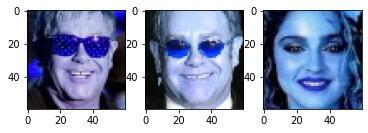

In [ ]:
idx = 999
plt.subplot(1,3,1)
plt.imshow(anchor_images[idx])

plt.subplot(1,3,2)
plt.imshow(same_images[idx])

plt.subplot(1,3,3)
plt.imshow(diff_images[idx])

In [ ]:
# It will generate 64 filters and multiply each of the accross the images
# and each will epoch will see which layer/filter is better and will memorize the parameter which is best suited for it for future purpose 
# hum kitne bhi layers lga sakte hen ... basically layers laagake hum apni
# image ko divide kar rahe hen several several parts me ..
# sequential model is linear stack of layers 
def get_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(img_size,img_size,3), activation='relu'))
    model.add(tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.Conv2D(64, kernel_size=1, strides=2, padding='same', activation='relu'))
    model.add(tf.keras.layers.Flatten())
#dense layer is making our decision boundary 
## it is takin saomme input and spitting out 512 dimensional vector
##overfiitting se bacahne ke liye dropout
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(128))
              
    model.summary()
    return model

In [ ]:
anchor_input = tf.keras.layers.Input((img_size, img_size, 3), name='anchor_input')
positive_input = tf.keras.layers.Input((img_size, img_size, 3), name='positive_input')
negative_input = tf.keras.layers.Input((img_size, img_size, 3), name='negative_input')

shared_dnn = get_model()

encoded_anchor = shared_dnn(anchor_input)
encoded_positive = shared_dnn(positive_input)
encoded_negative = shared_dnn(negative_input)

merged_vector = tf.keras.layers.concatenate([encoded_anchor, encoded_positive, encoded_negative],
                                            axis=-1, name='merged_layer')

model = tf.keras.Model(inputs=[anchor_input,positive_input, negative_input], outputs=merged_vector)
model.summary()
model.compile(loss=triplet_loss, optimizer="adam")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 15, 128)       73856     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 64)          73792     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 64)          4160      
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)              

In [ ]:

weight_dir = "weight_tripletloss_model"
if not os.path.exists(weight_dir):
    os.mkdir(weight_dir)
    
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=weight_dir+'/checkpoint-{epoch:02d}.hdf5')

In [ ]:
Y_dummy = np.empty((anchor_images.shape[0],1))

model.fit([anchor_images,same_images,diff_images],y=Y_dummy, batch_size=128, epochs=10, callbacks=[checkpoint])

Epoch 1/10
Tensor("model_2/merged_layer/concat:0", shape=(None, 384), dtype=float32)
Tensor("model_2/merged_layer/concat:0", shape=(None, 384), dtype=float32)
78/78 [==============================] - 119s 2s/step - loss: 8.7439
Epoch 2/10
78/78 [==============================] - 117s 2s/step - loss: 1.2416
Epoch 3/10
78/78 [==============================] - 121s 2s/step - loss: 0.4127
Epoch 4/10
78/78 [==============================] - 115s 1s/step - loss: 0.2242
Epoch 5/10
78/78 [==============================] - 117s 1s/step - loss: 0.2295
Epoch 6/10
78/78 [==============================] - 116s 1s/step - loss: 0.2352
Epoch 7/10
78/78 [==============================] - 117s 2s/step - loss: 0.1697
Epoch 8/10
78/78 [==============================] - 116s 1s/step - loss: 0.1500
Epoch 9/10
78/78 [==============================] - 125s 2s/step - loss: 0.0799
Epoch 10/10
78/78 [==============================] - 115s 1s/step - loss: 0.0460


In [ ]:
#given a new name to our model
anchor_model = tf.keras.Model(inputs = anchor_input, outputs=encoded_anchor)

In [ ]:
print(anchor_model)

In [ ]:
pred = anchor_model.predict(x_train)
pred.shape

(99, 128)

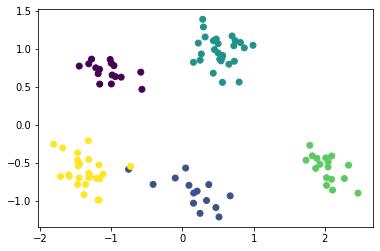

In [ ]:

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
#coverts to 2 coloumn 
pred_pca = pca.fit_transform(pred)

plt.scatter(pred_pca[:,0], pred_pca[:,1], c=y_train)
#c=train -> color kis bassis per karna he
# different clusters are representing 5 different classes

In [ ]:
# Encode the given test image 
def encode_image(model ,img):
    encode = model.predict(img.reshape((1,)+ img.shape))
    return encode

In [ ]:
#calculating the distance for KNN classification
def dist_imgs(anchor_enc, img_enc):
    return np.linalg.norm(img_enc - anchor_enc)

In [ ]:
print(df.head())

                                               image        name
0  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  elton_john
1  [[[127, 142, 168], [151, 164, 189], [159, 170,...  elton_john
2  [[[29, 29, 29], [30, 30, 30], [30, 30, 30], [3...  elton_john
3  [[[9, 16, 13], [7, 16, 13], [8, 17, 14], [6, 2...  elton_john
4  [[[187, 118, 78], [186, 117, 74], [183, 115, 7...  elton_john


In [ ]:
name_dict = {}
for i in set(df["name"].values):
    z = df[df["name"] == i].image
    img = np.array(list(z))/255
    enc = np.zeros((1,128))
    for j in range(len(z)):
        enc += encode_image(anchor_model,img[j])

    enc = enc/len(z)
    name_dict[i] = enc

In [ ]:
#predicte the image 
def predict_image(model, img, dictionary):
    enc = encode_image(model, img)
    max_dist = 10000000
    max_name = None
    for name in dictionary:
        dist = dist_imgs(dictionary[name], enc)
        if max_dist > dist:
            max_dist = dist
            max_name = name
    
    return max_name, max_dist

In [ ]:
pred_x_train = anchor_model.predict(x_train)

In [ ]:
## applied KNN classifier to our x_train and y_train
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=7)
neigh.fit(pred_x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

Predicted name: ['ben_afflek']
Actual pred:  ['ben_afflek']
[[ 0.28931493 -0.11398658 -0.13811778 -0.06403325  0.00866115  0.01702188
  -0.11680259  0.1319378   0.1374278  -0.16035268 -0.00822827 -0.06286119
   0.1625539  -0.19263515 -0.21658689  0.10772223  0.11834785  0.00953433
  -0.15260154 -0.00272444  0.11415263 -0.16049643 -0.11413786 -0.01501408
  -0.02795656  0.00644735 -0.05924479 -0.16761269 -0.14189246 -0.06032099
  -0.00311016 -0.09951394 -0.02491088 -0.02792604 -0.22399539  0.09400484
  -0.18068904 -0.09403123  0.10512175  0.1095659   0.10536801 -0.04483628
  -0.01742441 -0.13256496  0.06175873  0.18054591  0.0528903   0.04111804
  -0.18581432 -0.00126007 -0.04271895  0.03611251  0.20958252 -0.00863857
   0.29749998  0.06517155  0.08572975 -0.05225273  0.05686687 -0.01666399
  -0.06941425 -0.07015785 -0.08494751 -0.11403508  0.17596585  0.02688906
   0.11143801 -0.28634474  0.13482314 -0.0195022   0.00365242 -0.2842254
   0.15482725  0.12070224 -0.08407312  0.04289243  0.

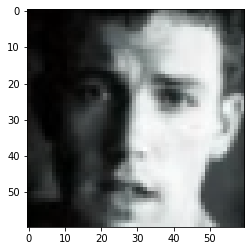

In [ ]:
#testing started 
idx = 16
img = x_test[idx]
plt.imshow(img)

enc = encode_image(anchor_model, img)
pred = neigh.predict(enc)
print("Predicted name:",le.inverse_transform(pred))
print("Actual pred: ", le.inverse_transform(y_test[idx:idx+1]))
print(enc)

Predicted name: ['ben_afflek']
Actual pred:  ['ben_afflek']
[[ 0.3581713  -0.15132427 -0.17100407 -0.05572395 -0.00278957  0.03337069
  -0.11900167  0.14929476  0.18350899 -0.21409681 -0.01326418 -0.06718544
   0.19147356 -0.21823224 -0.25103572  0.12799245  0.13521338  0.00571712
  -0.19071889 -0.0094178   0.13567111 -0.2061888  -0.1294864  -0.02896403
  -0.01852949 -0.00684771 -0.06770033 -0.17796293 -0.18699794 -0.06527551
  -0.02222813 -0.11378809 -0.03057584 -0.04614098 -0.28219417  0.10349764
  -0.21877065 -0.11611073  0.1354681   0.11532126  0.12282459 -0.06587064
  -0.02345555 -0.1581498   0.0827435   0.2236078   0.06085917  0.04489838
  -0.2154089   0.00298831 -0.06419038  0.05319344  0.2502364  -0.02950415
   0.3570847   0.07962999  0.073851   -0.06185955  0.05799801 -0.00414101
  -0.06154186 -0.0751214  -0.10278293 -0.14381175  0.21268456  0.04715332
   0.13235112 -0.34225187  0.16241847 -0.01150948 -0.00532268 -0.33243382
   0.16173382  0.13513695 -0.08829068  0.05780626  0

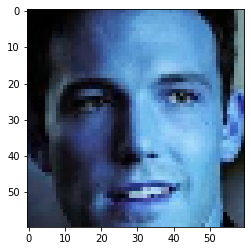

In [ ]:
idx = 17
img = x_test[idx]
plt.imshow(img)

enc = encode_image(anchor_model, img)
pred = neigh.predict(enc)
print("Predicted name:",le.inverse_transform(pred))
print("Actual pred: ", le.inverse_transform(y_test[idx:idx+1]))
print(enc)

Predicted name: ['mindy_kaling']
Actual pred:  ['mindy_kaling']
[[-0.12573878 -0.01501975 -0.16740917 -0.25885835  0.04001439 -0.14922418
  -0.22481824  0.11368848 -0.09160152  0.21533626  0.15191062 -0.1783553
  -0.01312945  0.12535372 -0.1691489   0.17454216  0.19446366 -0.11314379
  -0.06065685 -0.01699925 -0.03932207  0.2756056  -0.05545047  0.27102613
  -0.10200398  0.12582146 -0.06120281 -0.21414326 -0.12250819 -0.34877005
  -0.08445121  0.05127565 -0.03545533  0.07985155  0.13325532 -0.06468004
  -0.10075491  0.08515102  0.04980795  0.05459725  0.12177749 -0.09369152
   0.2477019   0.19955228 -0.34866384  0.08896951  0.07426161 -0.01117165
  -0.11298932 -0.10822836  0.2241288   0.08429113  0.04343065  0.32699734
  -0.17543519 -0.17419021 -0.07811398  0.0680166   0.08243088 -0.22419573
  -0.13287172 -0.12832882 -0.03656691 -0.0092767  -0.00240128 -0.2416992
   0.01995379  0.02450316  0.04311629 -0.13441272  0.17309089 -0.14374366
   0.18056443  0.22952892 -0.01231533  0.1899164  

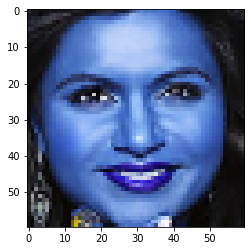

In [ ]:
idx = 7
img = x_test[idx]
plt.imshow(img)

enc = encode_image(anchor_model, img)
pred = neigh.predict(enc)
print("Predicted name:",le.inverse_transform(pred))
print("Actual pred: ", le.inverse_transform(y_test[idx:idx+1]))
print(enc)

In [ ]:
pred_x_test = anchor_model.predict(x_test)
pred = neigh.predict(pred_x_test)

print(np.sum(pred == y_test)/len(pred))

1.0
